# Library Used in Coding Assignment
Below code is for import all Python Packages
Below Packges have imported & its purpose

(1) numpy - numerical python scripts, to store array, list and other data

(2) scipy.stats - multivariate_normal to calculate the probability density function (pdf)

(2) matplotlib.pyplot - matplotlib's Pyplot packages to plot the data with the predicted mean from the EM's algo


In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Function Name = "log_sub_exp"
Below Function calculates Log Sum Expression


In [2]:
def log_sum_exp(Z):
    #Compute log(\sum_i exp(Z_i)) for Z (array)
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

# Function Name = "loglikelihood"


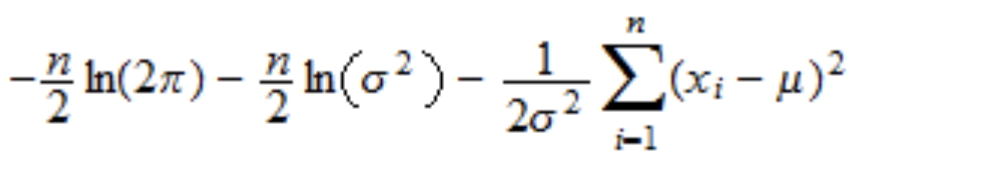


In [3]:
def loglikelihood(data, G, weights, means, covs):
    #Compute the loglikelihood of the data for a Gaussian mixture model
    num_clusters = G
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution
        ll += log_sum_exp(Z)
        
    return ll

# Function Name = "EStep"


In [4]:
# E-step
def EStep(data, G, init_weights, init_means, init_covariances):
    
    # Copy the initialize the variable
    weights = init_weights[:]    
    means = init_means[:]
    covariances = init_covariances[:]

    num_data = len(data)
    num_clusters = G # Number of Cluster

    # Initialize resp
    resp = np.zeros((num_data, num_clusters))
    
    #Loop
    for j in range(num_data):
        for k in range(num_clusters):
            resp[j, k] = weights[k]*multivariate_normal.pdf(data[j],means[k],covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize the responsibility
    return resp

# Function Name = "MStep"

This function is used to "Update Parameters" (weight, means and sigma) to maximize the likeliihood function 

In [5]:
# M-step        
def MStep(data, G, init_weights, init_means, init_covariances, resp):
    
    # Copy the initialize the variable
    weights = init_weights[:]
    means = init_means[:]
    covariances = init_covariances[:]

    num_data = len(data)
    num_dim = len(data[0])    
    num_clusters = G # Number of Cluster
    
    # Initialize some useful variables
    ll = loglikelihood(data, G, weights, means, covariances)
    ll_trace = [ll]
    
    counts = np.sum(resp, axis=0)
    
    for k in range(num_clusters):
        weights[k] = counts[k]/num_data
        weighted_sum = 0
        for j in range(num_data):
            weighted_sum += (resp[j,k]*data[j])
        means[k] = weighted_sum/counts[k]

        weighted_sum = np.zeros((num_dim, num_dim))
        for j in range(num_data):
            weighted_sum += (resp[j,k]*np.outer(data[j]-means[k],data[j]-means[k]))
        covariances[k] = weighted_sum/counts[k]

    # Compute the loglikelihood at this iteration
    ll_latest = loglikelihood(data, G, weights, means, covariances)
    ll_trace.append(ll_latest)

    ll = ll_latest
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_latest, 'resp': resp}
    return out

# Function Name = "myEM"

##### This function does the following

###### (1) Calls the EStep Function 
    - Takes the following Inputs as parameters
      - data
      - G - Number of Clusters
      - weights - Initial Weights
      - Means - Initial Means
      - Sigma - Initial covarience / Sigma

    - Outputs the following Parameter
      - responsibility - Probability

###### (2) Calls the MStep Function - Which will updates the parameters which maximize the likelihood functions
    - Takes the following Inputs as parameters
      - data
      - G - Number of Clusters
      - weights - Initial Weights
      - Means - Initial Means
      - Sigma - Initial covarience / Sigma
        
    - Outputs the following Parameter
      - weights - Final Updated
      - means - Final updated
      - sigma - Final Updated

###### (3) Print the Parameters after the X Iteration

In [6]:
def myEM(data, G, init_weights, init_means, init_covariances, maxiter=20):
    
    #Initlize the Parameters (weights, means, co-variances)
    upd_weights = init_weights
    upd_means = init_means
    upd_covs = init_covariances
    
    for i in range(maxiter):
        response = EStep(data, G, upd_weights, upd_means, upd_covs )
        out = MStep(data, G, upd_weights, upd_means, upd_covs, response)
        
        #Retrieve the Updates Parameters (weights, means and covariance)
        upd_weights = out['weights']
        upd_means = out['means']
        upd_covs = out['covs']
        
        #print("Iteration : {} - weights:{} means:{} sigma:{}".format(i,out['weights'],out['means'],out['covs'][0]))
        print("--------------------------------------------------------------------")
        print("Iteration : {}".format(i))
        print("--------------------------------------------------------------------")
        print("weights: {}".format(out['weights']))
        print("means  : {}".format(out['means']))
        print("sigma  : {}".format(out['covs'][0]))
        print("Log Likelihood  : {}".format(out['loglik']))
    
    return out

# Load the Data (Faithful.txt)

In [7]:
#Load the Data
X = np.loadtxt('../data/Faithful.txt')
print ("Data Loaded Successfully...")
print ("First 10 rows from the Faithful Dataset")
print (X[1:11,:])
print ("------------------------------------------")
print ("Size of the Dataset is: {}".format(X.shape))

Data Loaded Successfully...
First 10 rows from the Faithful Dataset
[[ 1.8   54.   ]
 [ 3.333 74.   ]
 [ 2.283 62.   ]
 [ 4.533 85.   ]
 [ 2.883 55.   ]
 [ 4.7   88.   ]
 [ 3.6   85.   ]
 [ 1.95  51.   ]
 [ 4.35  85.   ]
 [ 1.833 54.   ]]
------------------------------------------
Size of the Dataset is: (272, 2)


# Testing the Function myFunc  - 2 Cluster


###### Initialize the following 3 Parameters with the value

(1) weights / prob = 
          [0.50062804,0.49937196]

(2) means = 
          [3.467750,70.132353]
          [3.5078162,71.6617647]


(3) covariances / sigma = 
          [1.2975376,13.9110994]
          [13.911099,183.559040]


###### Called the Function myEM and takes the final updated parameters

In [8]:
#Two Cluster Initialization
init_weights = [0.50062804,0.49937196]
init_means = [np.array([3.467750,70.132353]),np.array([3.5078162,71.6617647])]
init_covs = [np.array([[1.2975376,13.9110994],[13.911099,183.559040]])]*2

itmax = 20 # Number of Iterations
K = len(init_weights) #Number of Clusters

out = myEM(data=X, 
           G=K, 
           init_weights = init_weights, 
           init_means = init_means, 
           init_covariances = init_covs, 
           maxiter=itmax)


--------------------------------------------------------------------
Iteration : 0
--------------------------------------------------------------------
weights: [0.5006526542469939, 0.49934734575300627]
means  : [array([ 3.46776969, 70.13260977]), array([ 3.5078488 , 71.66350617])]
sigma  : [[  1.32238528  14.18954649]
 [ 14.18954649 185.91012994]]
Log Likelihood  : -1289.7025659865567
--------------------------------------------------------------------
Iteration : 1
--------------------------------------------------------------------
weights: [0.5006785992293412, 0.49932140077065895]
means  : [array([ 3.46294816, 70.05882059]), array([ 3.51268552, 71.73757547])]
sigma  : [[  1.32938684  14.26608737]
 [ 14.26608737 186.1097399 ]]
Log Likelihood  : -1289.6481589287955
--------------------------------------------------------------------
Iteration : 2
--------------------------------------------------------------------
weights: [0.5007092780713915, 0.4992907219286086]
means  : [array([ 3.

# Output (weights / prob, means, sigma) from "myFunc"  - 2 Cluster

In [9]:
print ("weight - 2 Cluster :  {}".format(out['weights']))
print ("   ")
print ("means - 2 Cluster  :  {}".format(out['means']))
print ("   ")
print ("sigma - 2 Cluster  :  {}".format(out['covs'][0]))
print ("   ")
print ("loglikelihood - 2 Cluster  :  {}".format(out['loglik']))

weight - 2 Cluster :  [0.5036365730555206, 0.4963634269444796]
   
means - 2 Cluster  :  [array([ 2.73291856, 61.53818513]), array([ 4.25370854, 80.39306683])]
   
sigma - 2 Cluster  :  [[  1.15708628  11.82112052]
 [ 11.82112052 149.17019173]]
   
loglikelihood - 2 Cluster  :  -1223.957314616496


# Testing the Function myFunc  - 3 Cluster

###### Initialize the following 3 Parameters with the value

(1) weights / prob = 
          [0.30514706,0.34926471,0.34558824]

(2) means = 
          [3.4459639,69.8433735]
          [3.6217053,72.1578947]
          [3.3893617,70.5531915]

(3) covariances / sigma = 
          [1.2877935,13.842302]
          [13.8423020,183.208932]
          
          
###### Called the Function myEM and takes the final updated parameters          

In [10]:
#Three Cluster Initialization
init_weights = [0.30514706,0.34926471,0.34558824]
init_means = [np.array([3.4459639,69.8433735]),np.array([3.6217053,72.1578947]),np.array([3.3893617,70.5531915])]
init_covs = [np.array([[1.2877935,13.842302],[13.8423020,183.208932]])]*3

itmax = 20 # Number of Iterations
K = len(init_weights) #Number of Clusters

out = myEM(data=X, 
           G=K, 
           init_weights = init_weights, 
           init_means = init_means, 
           init_covariances = init_covs, 
           maxiter=itmax)


--------------------------------------------------------------------
Iteration : 0
--------------------------------------------------------------------
weights: [0.3051408625243811, 0.34929799829118785, 0.34556113918443054]
means  : [array([ 3.44630616, 69.85042535]), array([ 3.62064297, 72.13856517]), array([ 3.39011184, 70.56633575])]
sigma  : [[  1.33024023  14.32319609]
 [ 14.32319609 187.80379665]]
Log Likelihood  : -1289.593637935827
--------------------------------------------------------------------
Iteration : 1
--------------------------------------------------------------------
weights: [0.305117052669013, 0.34932678874147133, 0.34555615858951577]
means  : [array([ 3.43660804, 69.72137797]), array([ 3.63621595, 72.31525135]), array([ 3.38291679, 70.50148676])]
sigma  : [[  1.34132636  14.45477494]
 [ 14.45477494 188.65742396]]
Log Likelihood  : -1289.4793856804965
--------------------------------------------------------------------
Iteration : 2
-----------------------------

--------------------------------------------------------------------
Iteration : 19
--------------------------------------------------------------------
weights: [0.24232013605096772, 0.630408779925464, 0.12727108402356857]
means  : [array([ 1.98003614, 53.3049878 ]), array([ 4.31128663, 80.23636033]), array([ 2.27944563, 58.13167198])]
sigma  : [[ 0.03776105  0.12703753]
 [ 0.12703753 27.07162665]]
Log Likelihood  : -1122.9565396676417


# Output (weights / prob, means, sigma) from "myFunc" - 3 Cluster

In [11]:
print ("weight - 3 Cluster :  {}".format(out['weights']))
print ("   ")
print ("means - 3 Cluster  :  {}".format(out['means']))
print ("   ")
print ("sigma - 3 Cluster  :  {}".format(out['covs'][0]))
print ("   ")
print ("loglikelihood - 3 Cluster  :  {}".format(out['loglik']))

weight - 3 Cluster :  [0.24232013605096772, 0.630408779925464, 0.12727108402356857]
   
means - 3 Cluster  :  [array([ 1.98003614, 53.3049878 ]), array([ 4.31128663, 80.23636033]), array([ 2.27944563, 58.13167198])]
   
sigma - 3 Cluster  :  [[ 0.03776105  0.12703753]
 [ 0.12703753 27.07162665]]
   
loglikelihood - 3 Cluster  :  -1122.9565396676417
